# Signals Analysis

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('talk')

# Preprocessing

In [9]:
workingDirectory = '/home/jtao/analysis/signals_analysis/'
os.chdir(workingDirectory)

In [10]:
%%capture
!summarize_logs.py atac ./qc_atac ./tag_directories_atac/*/
!summarize_logs.py rna ./qc_rna ./tag_directories_rna/*/
!summarize_logs.py gro ./qc_gro ./tag_directories_gro/*/
!summarize_logs.py gro ./qc_5gro ./tag_directories_g5ro/*/




In [11]:
summary_atac_frame = pd.read_csv('./qc_atac/mapping_stats.tsv', sep='\t')
summary_atac_frame['genome'] = 'mm10'
sample_names = summary_atac_frame['sample'].values
summary_atac_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_atac_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_atac_frame['treatment'] = [x.split('_')[3] for x in sample_names]



## C57Bl6 ATAC-seq

### Mapping Quality Control

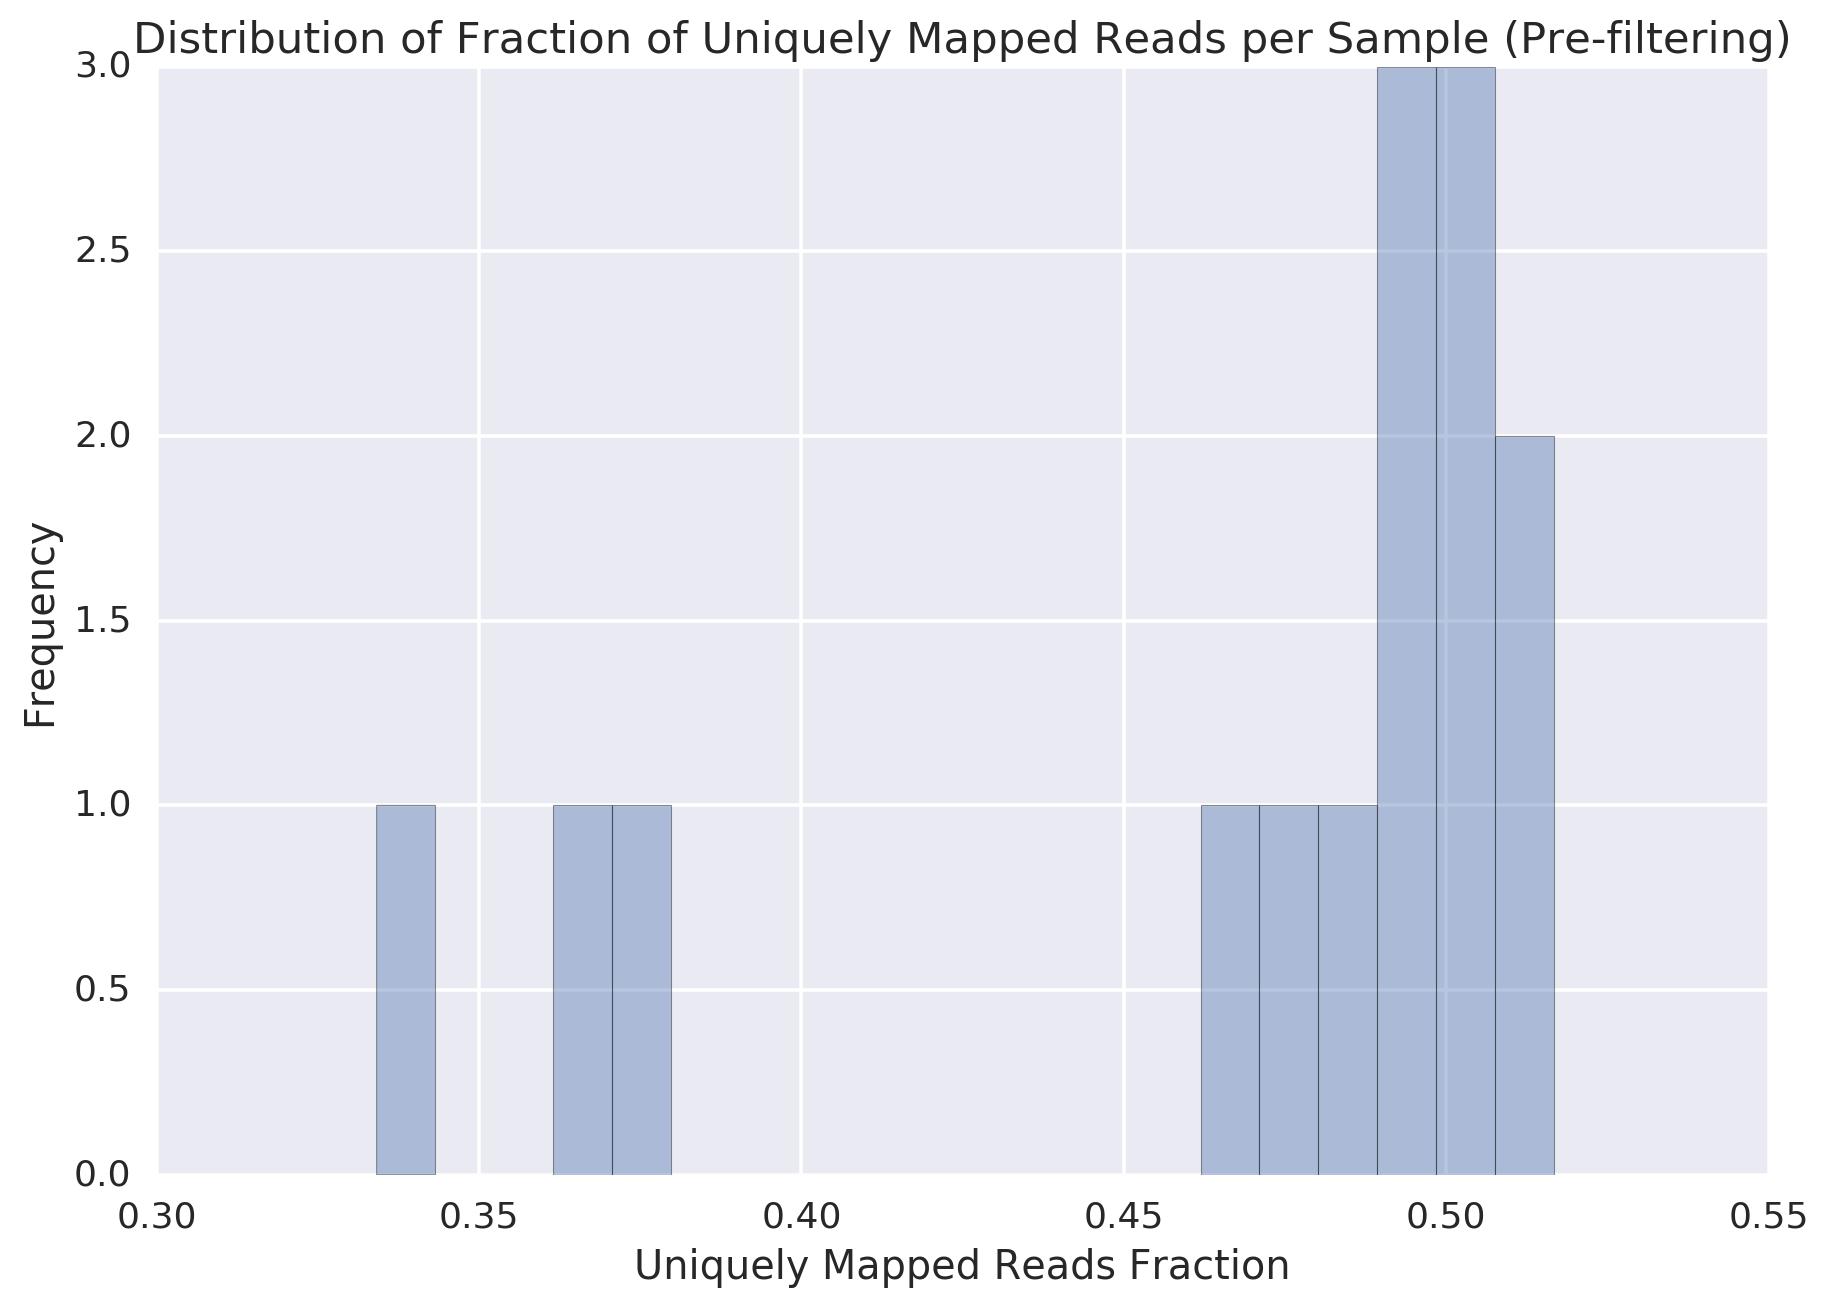

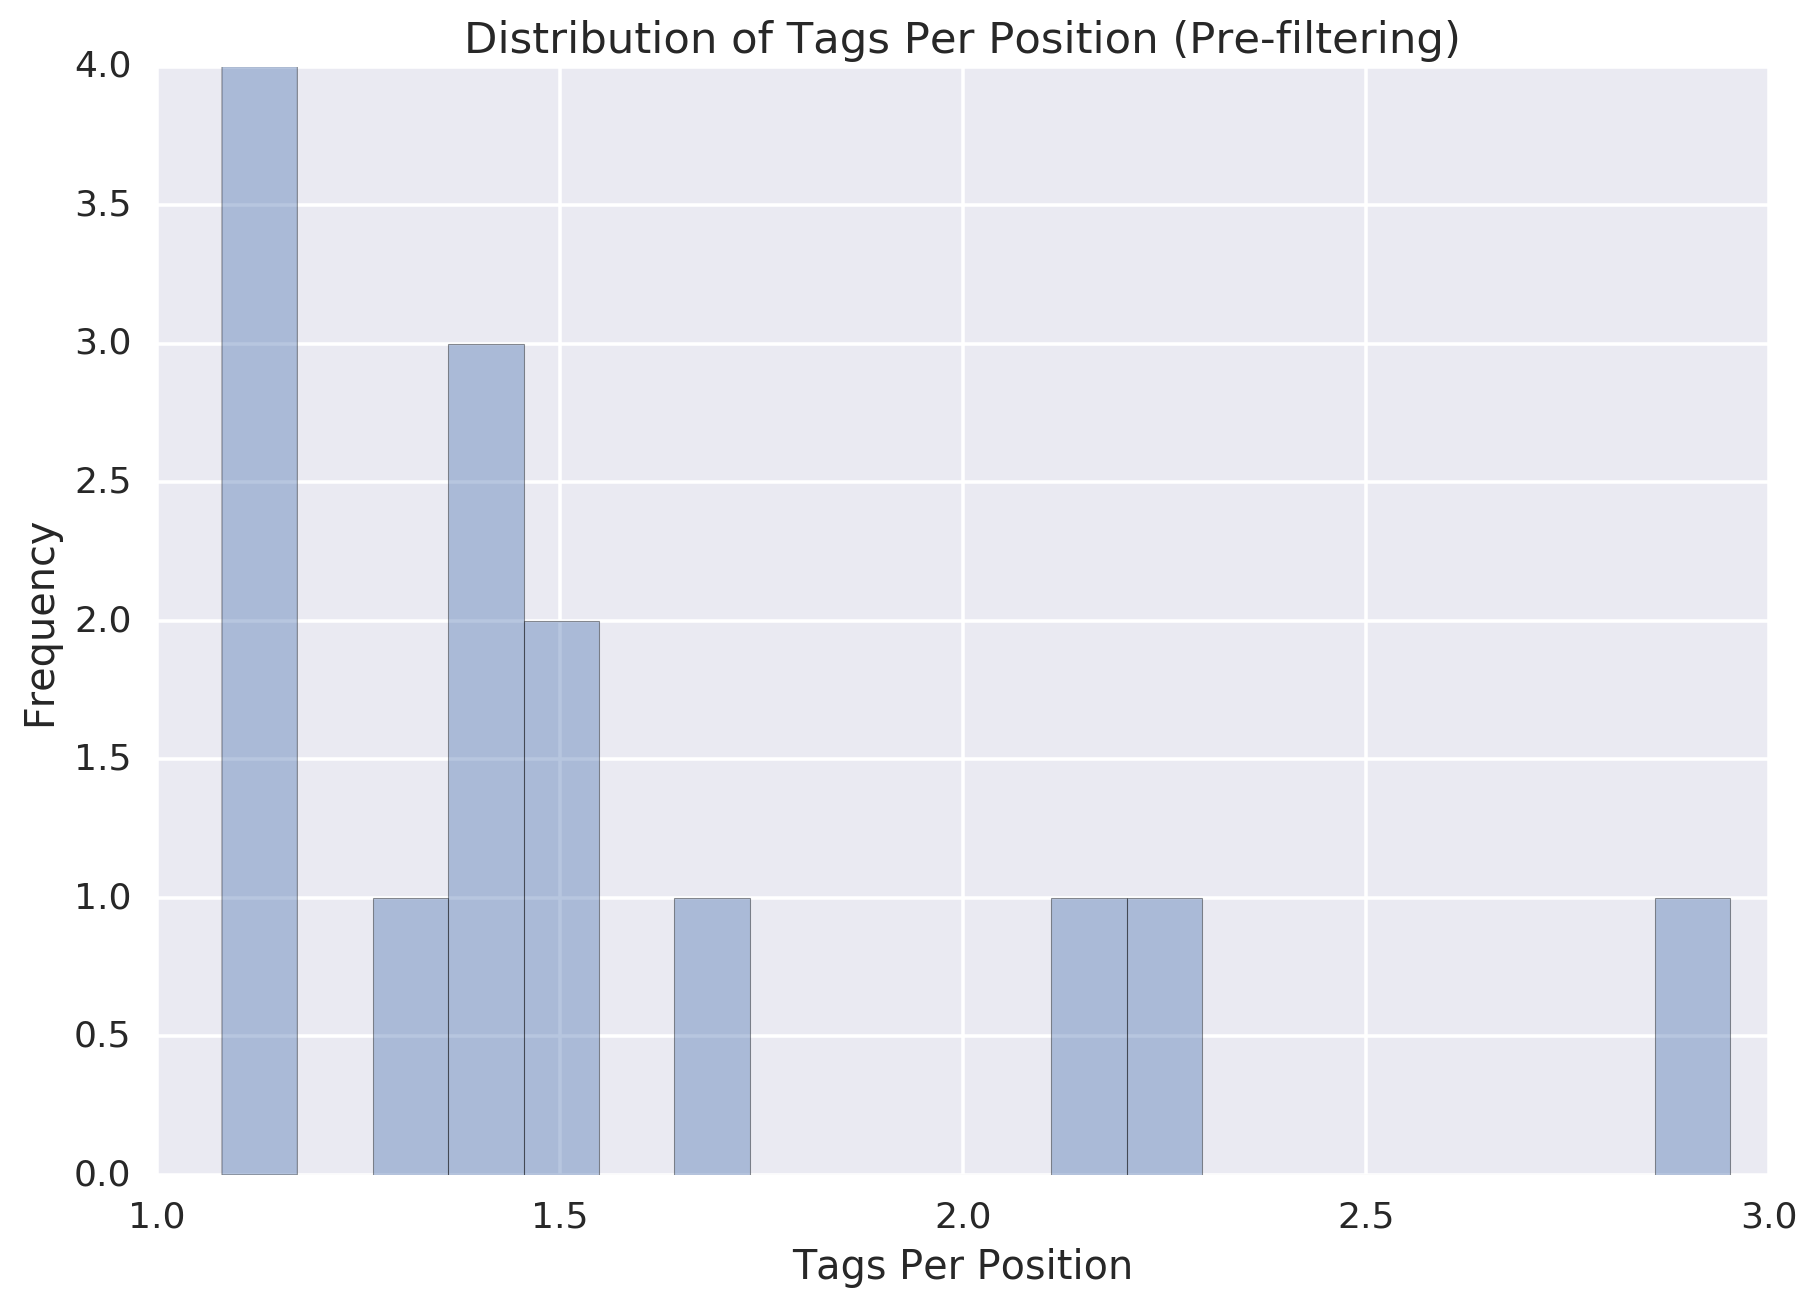

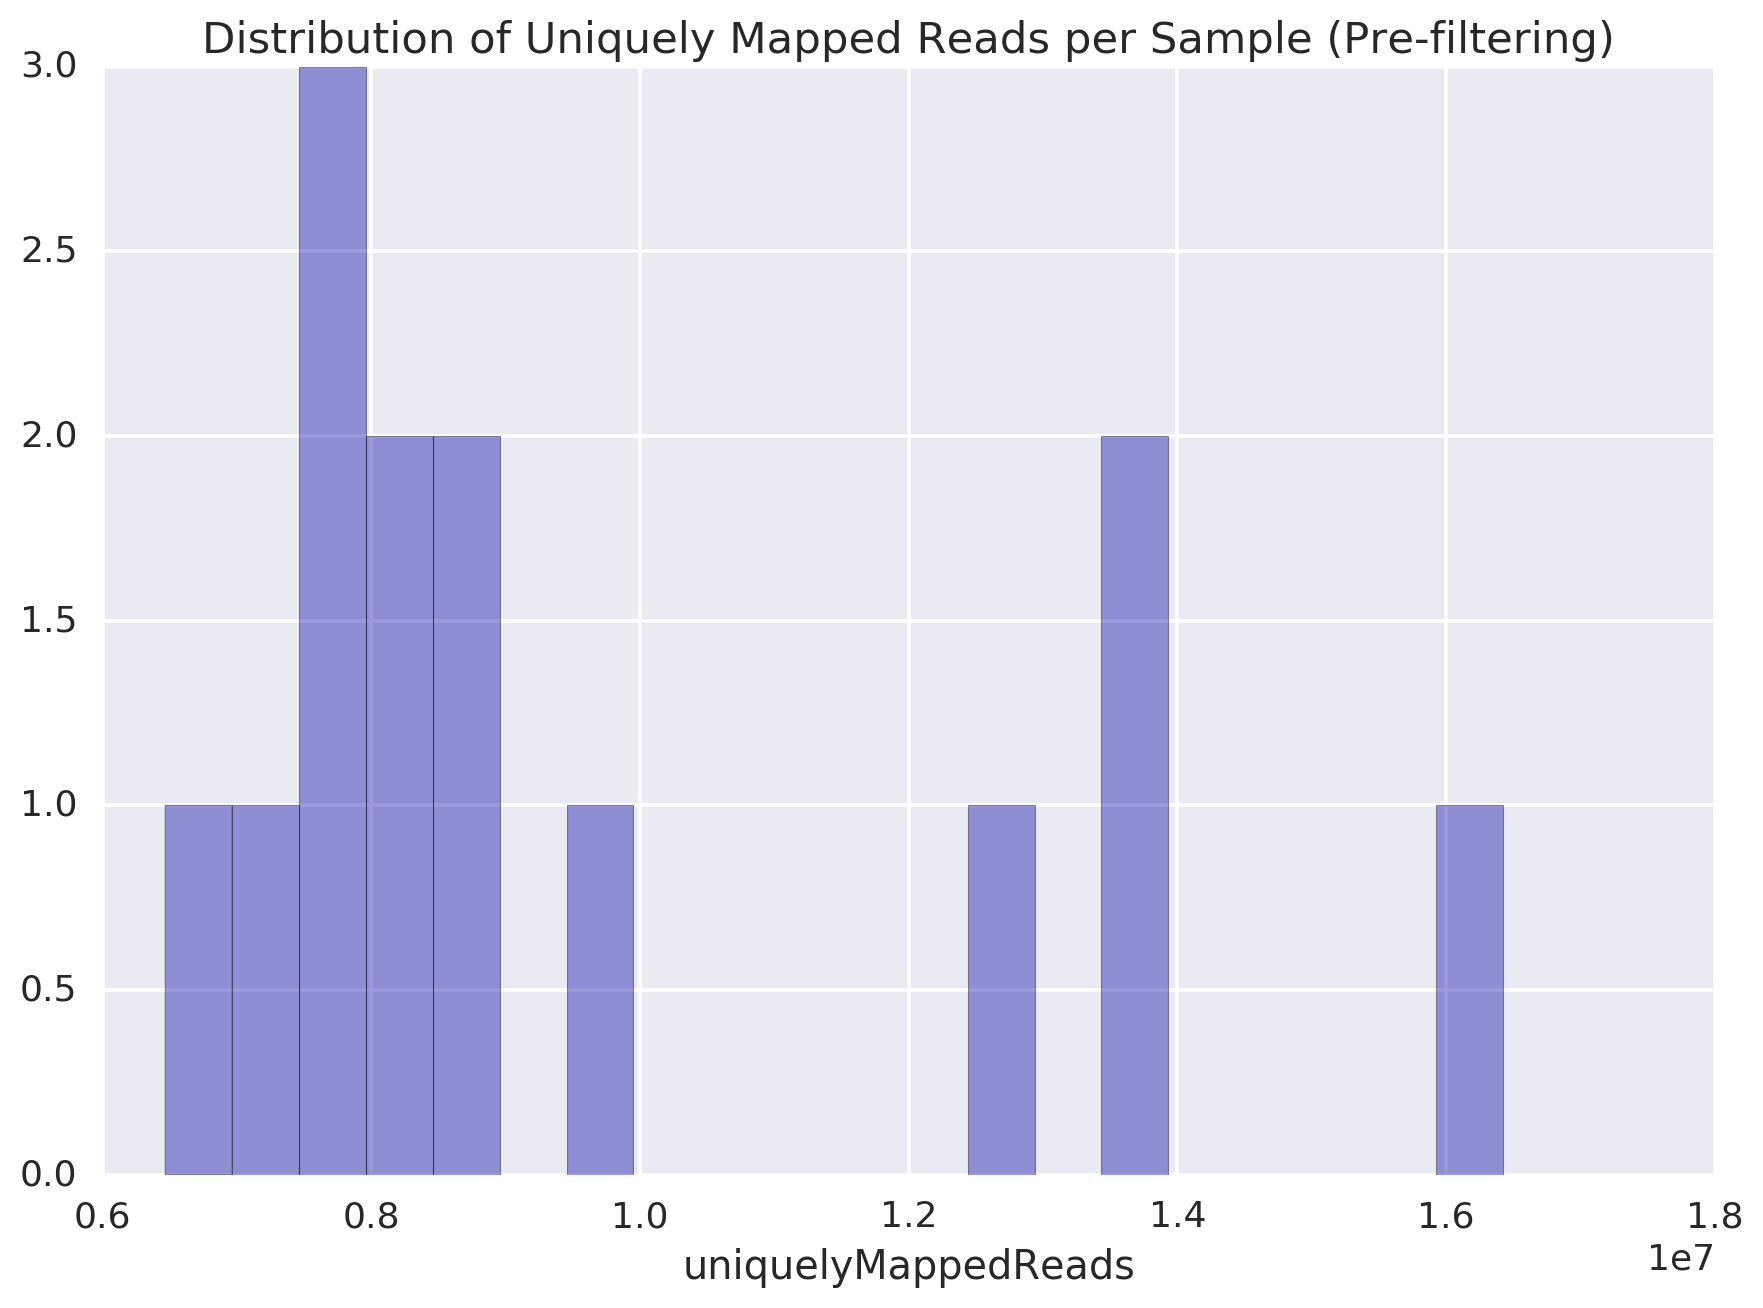

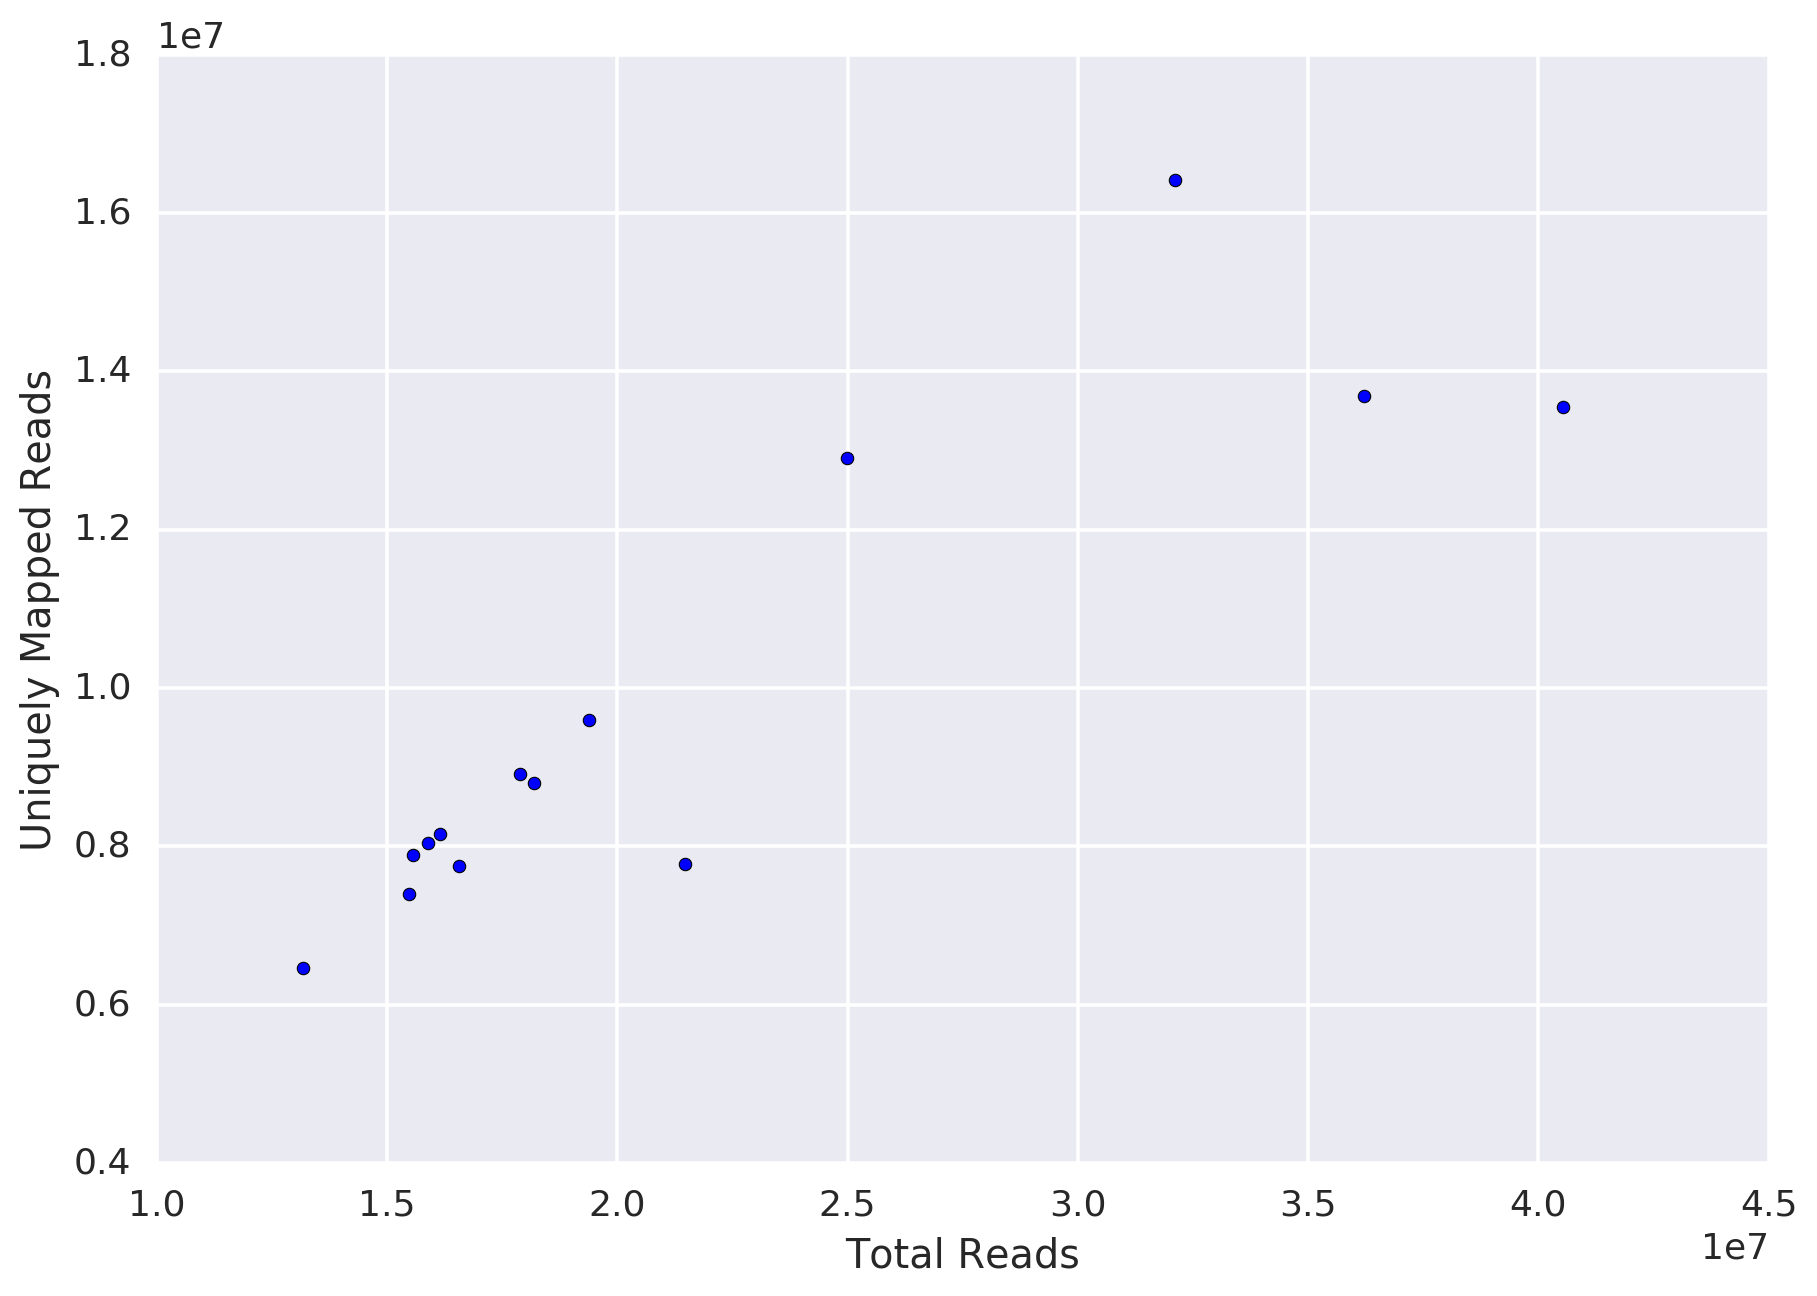

In [12]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_atac_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_atac_frame['clonality'].values, bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()


# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_atac_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.show()


plt.scatter(x = summary_atac_frame['totalReads'].astype(float).values, y=summary_atac_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Total Reads')
plt.ylabel('Uniquely Mapped Reads')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [13]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 0

filtered_summary_atac_frame = summary_atac_frame.copy()
# # filter on fraction of mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['mappedFraction'] >= mappedFractionThreshold]
# # filter on total mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_atac_frame['sample'].values if not x in filtered_summary_atac_frame['sample'].values]
discarded_summary_atac_frame = summary_atac_frame[summary_atac_frame['sample'].isin(discardedSampleNames)]
print("Number of Samples:", summary_atac_frame.shape[0])
print("Number of discarded samples:",discarded_summary_atac_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_atac_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_atac_frame['strain'] 
                            + '_' + filtered_summary_atac_frame['treatment'] 
                            + '_' + filtered_summary_atac_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_atac_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_atac_frame['sample'].values,
                                       filtered_summary_atac_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_atac_frame['simplifiedName'].values,
                                       filtered_summary_atac_frame['sample'].values))



Number of Samples: 14
Number of discarded samples: 0
Number of Samples remaining after filtering: 14


### Peak Calling

In [27]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'atac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_idr.sh', 'w')
scriptFile2 = open('./peakCalling_homer.sh', 'w')

atacTagDirPath = './tag_directories_atac/'
for tagDir in filtered_summary_atac_frame['sample'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 150  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + atacTagDirPath + '/' + tagDir
                 + ' -style factor -size 150 > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



In [28]:
%%bash
rm ./atac_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_idr.sh

	Fragment Length = 79
	Total Tags = 3870993.0
	Tags per bp = 0.001935
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 78
	Total Tags = 3522168.0
	Tags per bp = 0.001761
	Max tags per bp set automatically to 1.0
	Fragment Length = 87
	Finding peaks of size 150, no closer than 300
	Total Tags = 4845257.0
	Tags per bp = 0.002423
	Max tags per bp set automatically to 1.0
	Fragment Length = 65
	Total Tags = 2749270.0
	Tags per bp = 0.001375
	Max tags per bp set automatically to 1.0
	Fragment Length = 78
	Total Tags = 3662432.0
	Tags per bp = 0.001831
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Finding peaks of size 150, no closer than 300
	Finding peaks of size 150, no closer than 300
	Fragment Length = 67
	Total Tags = 5890799.0
	Tags per bp = 0.002945
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 81
	Total Tags = 3890810.0


### Run IDR

In [29]:
idrDirectory = './atac_idr/'
scriptFile = open('./run_idr.sh', 'w')
!rm ./atac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
replicateIndices = []


# homer peaks
counter = 0
for treatment in sorted(set(filtered_summary_atac_frame['treatment'])):
    samples = filtered_summary_atac_frame[filtered_summary_atac_frame['treatment'] == treatment]['simplifiedName'].values
    
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.05"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

In [30]:
%%bash
# rm ./ap1_idr/*
chmod a+x ./scratch/*
bash ./run_idr.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_tgfbeta-1h_sd338_1_peaks.tsv, /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_tgfbeta-1h_sd339_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//c57bl6_tgfbeta-1h_sd338_1_peaks.narrowPeak ./atac_idr//c57bl6_tgfbeta-1h_sd339_1_peaks.narrowPeak --output-file ./atac_idr//c57bl6_tgfbeta-1h_sd338_1_peaks_c57bl6_tgfbeta-1h_sd339_1_peaks_idr.out --plot --idr-threshold 0.05 &
Performing IDR analysis on the following samples: /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_r848-1h_sd344_1_peaks.tsv, /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_r848-1h_sd345_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR

chmod: cannot access ‘./scratch/*’: No such file or directory
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.46 1.16 0.76 0.58]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.2-py3.5-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 11493/30892 (37.2%)

Number of peaks passing IDR cutoff of 0.05 - 11493/30892 (37.2%)

/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: FutureWarning: sort(....) is deprecated, use sort_index(.....)


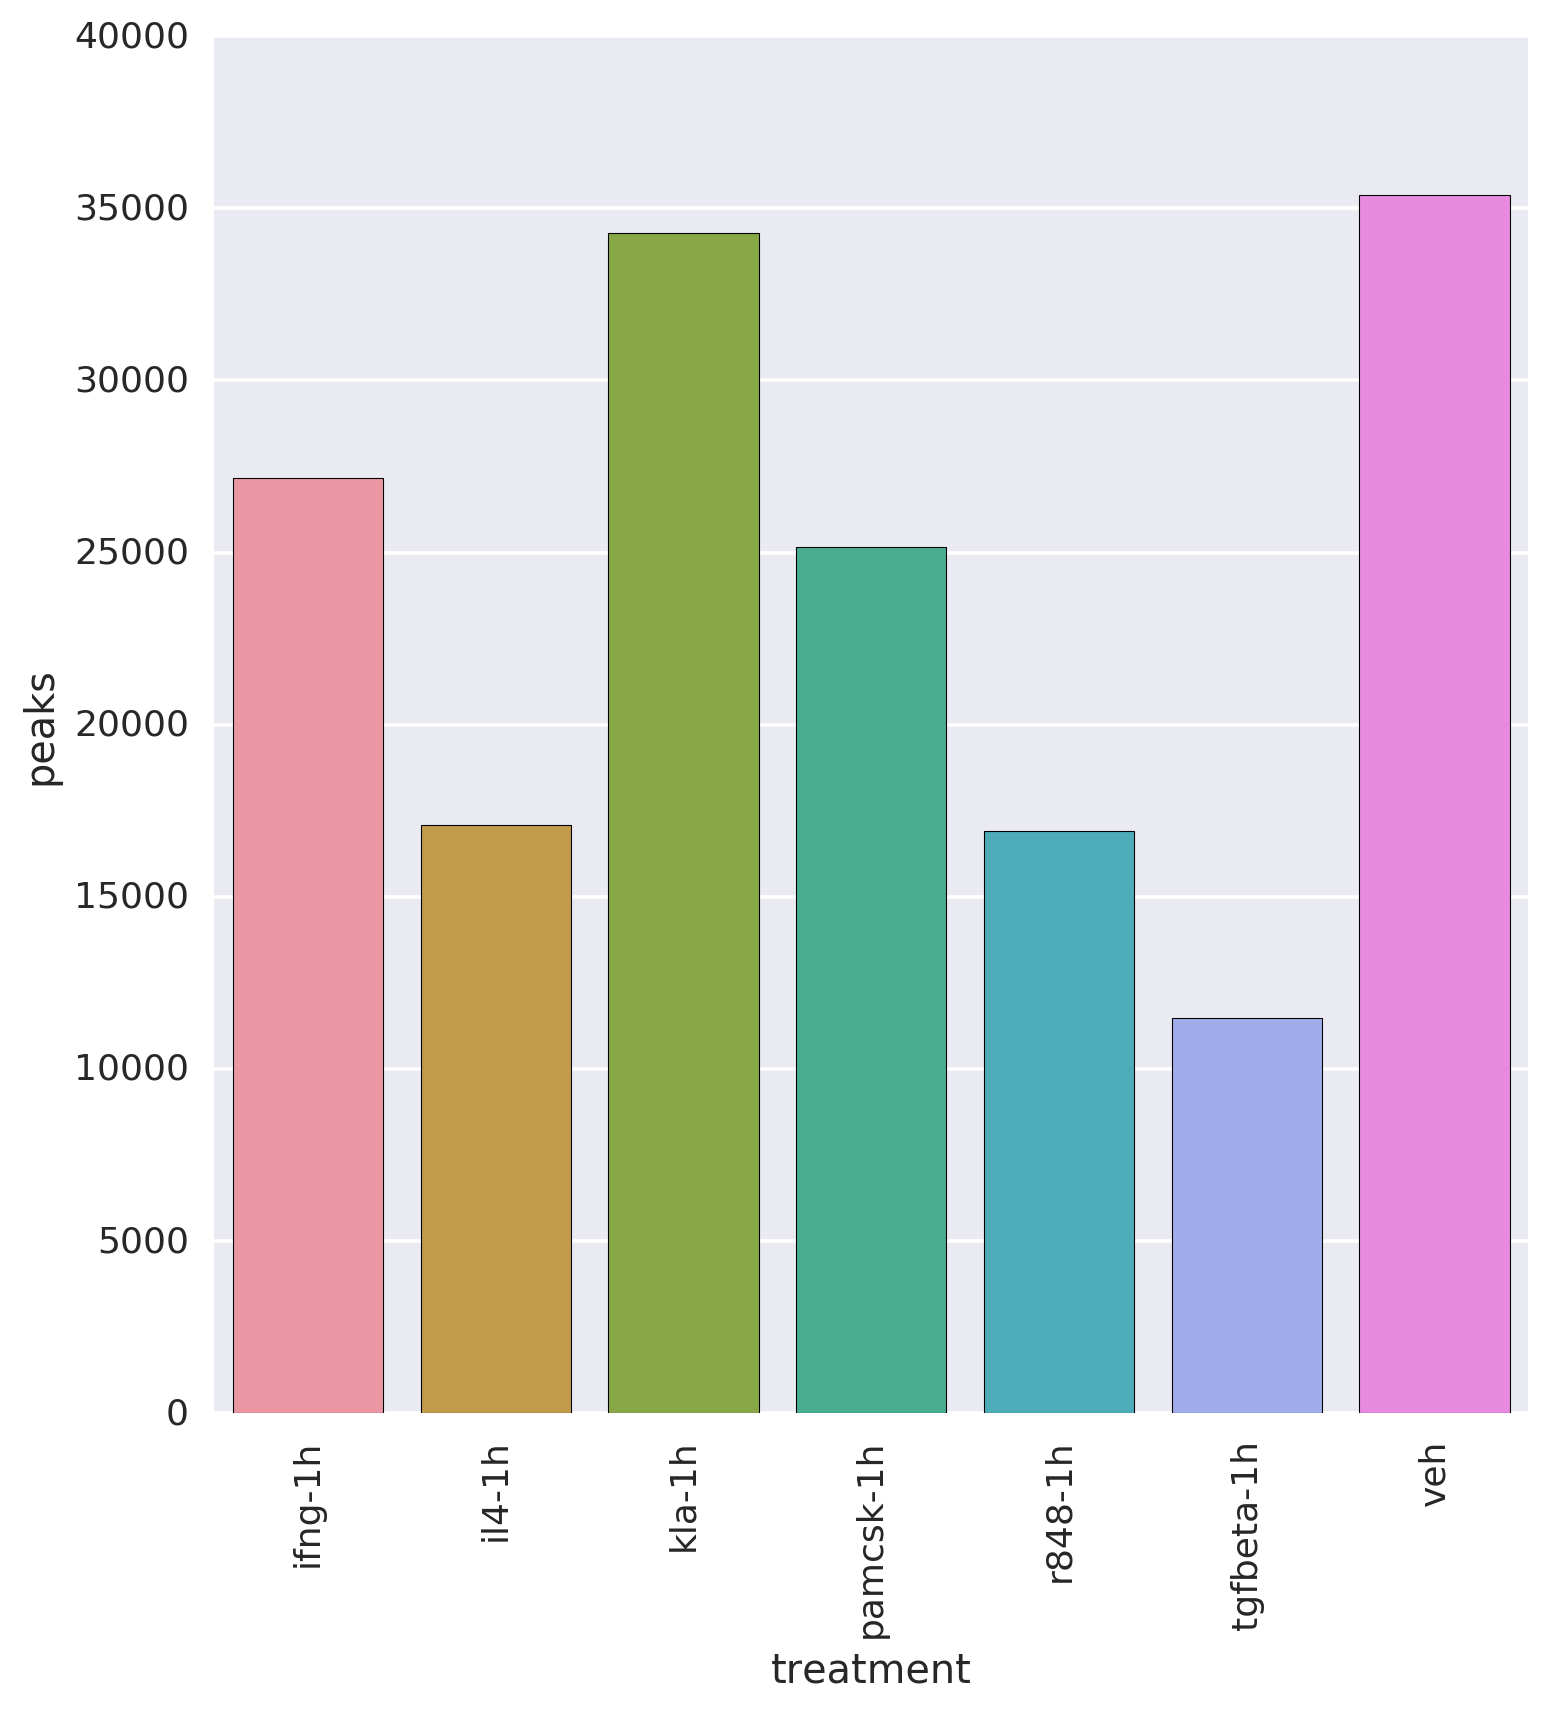

In [31]:
# pick the IDR results that have the most peaks
idrDirectory = './atac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:3])
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for treatment in treatment_peakNumber_dict.keys():
    tokens = treatment.split('_')
    strains.append(tokens[0])
    treatments.append(tokens[1])
    numPeaks.append(treatment_peakNumber_dict[treatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='treatment', y='peaks', data = idrPeak_frame, size =8, kind='bar')
plt.xticks(rotation=90);
# plt.ylim([0,30000])
    

In [13]:
# create track hub containing best samples
tagDirectories = []
# for key in sorted(treatment_bestIDR_dict.keys()):
for key in treatment_bestIDR_dict.keys():
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_atac/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl signals_atac mm10 -norm 1e6 -force -d $tagDirString
# ! makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString

makeMultiWigHub.pl signals_atac mm10 -norm 1e6 -fragLength 150 -normLength 150 -force -d ./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344 ./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345 ./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15 ./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06 ./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342 ./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343 ./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338 ./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337 ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15 ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06


In [32]:
outFile = open('./best_samples.tsv','w')
if not os.path.isdir('./atac_idr_peaks/'):
    os.mkdir('./atac_idr_peaks/')
else:
    for f in os.listdir('./atac_idr_peaks/'):
        os.remove('./atac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[1]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    outFile.write('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key]),'\n']))
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './atac_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()




c57bl6	ifng-1h	C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340	C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341	c57bl6_ifng-1h_sd340_1_peaks_c57bl6_ifng-1h_sd341_1_peaks_idr.tsv
c57bl6	il4-1h	C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336	C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337	c57bl6_il4-1h_sd336_1_peaks_c57bl6_il4-1h_sd337_1_peaks_idr.tsv
c57bl6	kla-1h	C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15	C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06	c57bl6_kla-1h_16-02-11-and-16-09-15_1_peaks_c57bl6_kla-1h_16-05-06_1_peaks_idr.tsv
c57bl6	pamcsk-1h	C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342	C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343	c57bl6_pamcsk-1h_sd342_1_peaks_c57bl6_pamcsk-1h_sd343_1_peaks_idr.tsv
c57bl6	r848-1h	C57Bl6_BMDM_ATAC_R848-1h_SD_SD344	C57Bl6_BMDM_ATAC_R848-1h_SD_SD345	c57bl6_r848-1h_sd344_1_peaks_c57bl6_r848-1h_sd345_1_peaks_idr.tsv
c57bl6	tgfbeta-1h	C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338	C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339	c57bl6_tgfbeta-1h_sd338_1_peaks_c57bl6_tgfbeta-1h_sd339_1_peaks_idr.tsv
c57bl6	veh	C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09

## Merge Peak Files

In [19]:
target_peak_size = 100

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./atac_idr_peaks/'):
    current_peak_frame = pd.read_csv('./atac_idr_peaks/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

In [20]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_atac_peaks.tsv

In [21]:
merged_frame = pd.read_csv('./merged_atac_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 200
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
! makeSummaryFile.py ./merged_atac_peaks_filtered_resized.tsv ./group_atac_summary.tsv ./resized_peak_files/*

Finished reading merged peak file...
Integrating scores for c57bl6_ifng-1h
Integrating scores for c57bl6_il4-1h
Integrating scores for c57bl6_kla-1h
Integrating scores for c57bl6_pamcsk-1h
Integrating scores for c57bl6_r848-1h
Integrating scores for c57bl6_tgfbeta-1h
Integrating scores for c57bl6_veh


In [23]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [24]:
!perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains C57BL6J -file ./merged_atac_peaks_filtered_resized.tsv -output ./peak_sequences/C57BL6J_marge.fa




Please specify following parameter(s) or use -h or --help to print help
	-ind




In [25]:
# reformat fastq files to use homer peak IDs

coordinate_peakID_dict = {} # {chr_start_end:homerID}
with open ('./merged_atac_peaks_filtered_resized.tsv') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    coordinate = '_'.join(tokens[1:4])
    peakID = tokens[0].strip()
    coordinate_peakID_dict[coordinate] = tokens[0]

In [26]:
for fastaFile in os.listdir('./peak_sequences/'):
    if 'marge' in fastaFile:
        strain = fastaFile.split('_')[0]
        outFile = open('./peak_sequences/' + fastaFile.replace('_marge',''), 'w')
        print(fastaFile)
        with open('./peak_sequences/' + fastaFile) as f:
            data = f.readlines()
        for line in data:
            if '>' in line:
                coordinate = line[1:].replace('_'+strain,'').strip()
                
                peakID = coordinate_peakID_dict[coordinate[:-2] ] # verena's script appends '_1' for some reason
                outFile.write('>' + peakID + '\n')
               
            else:
                outFile.write(line)
        outFile.close()

In [147]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/signals_analysis/fimo_results/ ]; then mkdir /home/jtao/analysis/signals_analysis/fimo_results/; fi
! rm -rf fimo_out/*
! rm -rf fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]
        count = 0
        scriptFile = open('scanMotifs_'+ strain +'.sh','w')
        for m in sorted(os.listdir(motif_dir)):
            if 'fimo' in m:
                fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
                outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
                scriptFile.write(
        #             '(sleep ' + str(15 * count) + 
                    '(sleep ' + str(0 * count) + 
                    's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                    str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
                    motif_dir + '/' + m + ' ./peak_sequences/' + fastaFile +
                    '> ' + outPath + ' ) & \n')
                count+=1
        scriptFile.close()

C57BL6J.fa


In [ ]:
%%bash
chmod a+x ./scanMotifs*
./scanMotifs_C57BL6J.sh

In [8]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')

# Call TSS using 5'GRO'

In [25]:
summary_gro_frame = pd.read_csv('./qc_gro/mapping_stats.tsv', sep='\t')
summary_gro_frame['genome'] = 'mm10'
sample_names = summary_gro_frame['sample'].values
summary_gro_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_gro_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_gro_frame['treatment'] = [x.split('_')[3] for x in sample_names]

summary_5gro_frame = pd.read_csv('./qc_5gro/mapping_stats.tsv', sep='\t')
summary_5gro_frame['genome'] = 'mm10'
sample_names = summary_5gro_frame['sample'].values
summary_5gro_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_5gro_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_5gro_frame['treatment'] = [x.split('_')[3] for x in sample_names]


In [28]:
treatments = sorted(set(summary_5gro_frame['treatment'].values))

In [89]:
tag_dir_path_5gro = './tag_directories_5gro/'
tag_dir_path_gro = './tag_directories_gro/'
tss_path = './tss_scratch/'
tss_final_path = './tss/'

In [93]:
for treatment in treatments:
    print(treatment)
    samples_gro = summary_gro_frame[summary_gro_frame['treatment'] == treatment]['sample'].values
    samples_5gro = summary_5gro_frame[summary_5gro_frame['treatment'] == treatment]['sample'].values
    # call TSS using both GRO as input for each 5GRO experiment
    counter_5gro = 1
    replicate_list = []
    for samp_5gro in samples_5gro:
        command = 'findPeaks ' + tag_dir_path_5gro + samp_5gro + ' -norm 1e6 -style tss' 
        counter_gro = 1
        tss_path_list = []
        for samp_gro in samples_gro:
            current_command = command + ' -i '+ tag_dir_path_gro + samp_gro + ' -o '
            current_tss_path = tss_path + treatment + '_rep' + str(counter_5gro) + '_input' + str(counter_gro) + '_tss.tsv'
            current_command = current_command + ' ' + current_tss_path
            counter_gro += 1
            tss_path_list.append(current_tss_path)
            if not os.path.isfile(current_tss_path):
                os.system(current_command)
        # merge tss called using different inputs together
        merge_command = 'mergePeaks ' + ' '.join(tss_path_list) + ' -prefix ' + tss_path + treatment
        os.system(merge_command)
        # rename intersection file
        intersection_path = treatment + '_.' + '_.'.join([x.replace('./','_').replace('/','_') for x in tss_path_list])
        renamed_intersection_path = tss_path + treatment + '_rep'+str(counter_5gro) + '_tss.tsv'
        os.system('cp ' + tss_path+  intersection_path + ' '+ renamed_intersection_path)
        replicate_list.append(renamed_intersection_path)
        counter_5gro += 1
    # merge replicates
    merge_command = 'mergePeaks ' + ' '.join(replicate_list) + ' -prefix ' + tss_path + treatment
    os.system(merge_command)
    # rename merged replicate
    merged_replicate_path = treatment + '_.' + '_.'.join([x.replace('./','_').replace('/','_') for x in replicate_list])
    renamed_merged_replicate_path = tss_final_path + treatment + '_tss.tsv'
    os.system('mv ' + tss_path+  merged_replicate_path + ' '+ renamed_merged_replicate_path)


KLA-1h
Veh


## Read in Score Pickles

In [23]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
motif_count_frame=pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')

   

In [24]:
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_C57BL6J.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_C57BL6J.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_C57BL6J.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_C57BL6J.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_C57BL6J.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_C57BL6J.pickle')

# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]



In [35]:
columns = list(motif_score_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)
motif_score_frame = motif_score_frame[sorted_columns]
motif_sequence_frame = motif_sequence_frame[sorted_columns]
motif_strand_frame = motif_strand_frame[sorted_columns]
motif_start_frame = motif_start_frame[sorted_columns]
motif_end_frame = motif_end_frame[sorted_columns]
motif_count_frame = motif_count_frame[sorted_columns]

motif_score_background_frame = motif_score_background_frame[sorted_columns]
motif_sequence_background_frame = motif_sequence_background_frame[sorted_columns]
motif_strand_background_frame = motif_strand_background_frame[sorted_columns]
motif_start_background_frame = motif_start_background_frame[sorted_columns]
motif_end_background_frame = motif_end_background_frame[sorted_columns]
motif_count_background_frame = motif_count_background_frame[sorted_columns]

In [36]:
# concatent target and background frames
# scores
all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_score_frame = all_score_frame[motif_score_frame.columns.values]
all_score_frame = all_score_frame[sorted_columns]

# counts
all_count_frame = pd.concat([motif_count_frame, motif_count_background_frame])
all_count_frame = all_count_frame[motif_count_frame.columns.values]
all_count_frame = all_count_frame.ix[:,3:]
all_count_frame = all_count_frame[sorted(all_count_frame.columns.values)]

scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values
all_standardized_score_frame = all_standardized_score_frame[sorted(all_standardized_score_frame.columns.values)]

scaler = preprocessing.MinMaxScaler()
all_normed_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_normed_score_frame.columns = all_score_frame.columns.values[3:]
all_normed_score_frame.index = all_score_frame.index.values
all_normed_score_frame = all_normed_score_frame[sorted(all_normed_score_frame.columns.values)]

scaler = preprocessing.StandardScaler()
all_standardized_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
all_standardized_count_frame.columns = all_count_frame.columns.values
all_standardized_count_frame.index = all_count_frame.index.values
all_standardized_count_frame = all_standardized_count_frame[sorted(all_standardized_count_frame.columns.values)]

scaler = preprocessing.MinMaxScaler()
all_normed_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
all_normed_count_frame.columns = all_count_frame.columns.values
all_normed_count_frame.index = all_count_frame.index.values
all_normed_count_frame = all_normed_count_frame[sorted(all_normed_count_frame.columns.values)]

## Run Model

In [47]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [48]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [49]:
def train_ensemble_classifier(affinity_features,
                              count_features, 
                              labels,
                              numIterations = 5,
                              test_size = 0.5,
                             ):
    '''
    
    '''
    all_rocs = []
    all_affinity_rocs = []
    all_count_rocs = []

    all_precisions = []
    all_affinity_precisions = []
    all_count_precisions = []
    
    all_coefficients = []
    all_affinity_coefficients = []
    all_count_coefficients = []

    for i in range(numIterations):  

        # split data into training and test sets
        training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
            affinity_features, labels, test_size = test_size)
        training_count_features = count_features[count_features.index.isin(training_affinity_features.index.values)]
        test_count_features = count_features[count_features.index.isin(test_affinity_features.index.values)]
        #  Train affinity classifier
        affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        affinity_classifier.fit(training_affinity_features, training_labels)

        # Train count classifier
        count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        count_classifier.fit(training_count_features, training_labels)

        # train combined classifier
        training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
        training_count_scores = count_classifier.decision_function(training_count_features)
        training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                         'Count':training_count_scores})
        combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        combined_classifier.fit(training_combined_features, training_labels)

        # retrieve test probabilities
        test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
        test_count_scores = count_classifier.decision_function(test_count_features)
        test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                   'Count':test_count_scores})

        # score predictions
        affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
        current_affinity_rocs = sklearn.metrics.roc_auc_score(test_labels, affinity_probas[:, 1], average = None)
        current_affinity_precision = sklearn.metrics.average_precision_score(test_labels, affinity_probas[:, 1], average = None)
        
        count_probas = count_classifier.predict_proba(test_count_features)
        current_count_rocs = sklearn.metrics.roc_auc_score(test_labels, count_probas[:, 1], average = None)
        current_count_precision = sklearn.metrics.average_precision_score(test_labels, count_probas[:, 1], average = None)
    
        probas = combined_classifier.predict_proba(test_combined_features)
        current_rocs = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
        current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

         # retrieve coefficients
        current_coefficients = combined_classifier.coef_.flatten()
        current_affinity_coefficients = affinity_classifier.coef_.flatten()
        current_count_coefficients = count_classifier.coef_.flatten()
        
        all_rocs.append(current_rocs)
        all_affinity_rocs.append(current_affinity_rocs)
        all_count_rocs.append(current_count_rocs)

        all_precisions.append(current_precision)
        all_affinity_precisions.append(current_affinity_precision)
        all_count_precisions.append(current_count_precision)

        all_coefficients.append(current_coefficients)
        all_affinity_coefficients.append(current_affinity_coefficients)
        all_count_coefficients.append(current_count_coefficients)      
    
#     mean_affinity_coefficients = np.mean(all_affinity_coefficients, axis=0)
#     mean_count_coefficients = np.mean(all_count_coefficients, axis=0)
        
    results = (all_rocs, 
               all_affinity_rocs, 
               all_count_rocs, 
               all_precisions, 
               all_affinity_precisions, 
               all_count_precisions,
               all_coefficients,
               all_affinity_coefficients,
               all_count_coefficients)
    return results





In [50]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0

In [51]:
from random import shuffle

import sklearn

from sklearn import cross_validation

from sklearn import linear_model

import scipy

In [78]:
summary_frame.columns.values[5:]

array(['c57bl6_ifng-1h', 'c57bl6_il4-1h', 'c57bl6_kla-1h',
       'c57bl6_pamcsk-1h', 'c57bl6_r848-1h', 'c57bl6_tgfbeta-1h',
       'c57bl6_veh'], dtype=object)

In [80]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_coeff_dict = {}
factor_affinityCoeff_dict = {}
factor_countCoeff_dict = {}

factor_roc_dict = {}
factor_affinity_roc_dict = {}
factor_count_roc_dict = {}

factor_precision_dict = {}
factor_affinity_precision_dict = {}
factor_count_precision_dict = {}

veh_indices = set(summary_frame[summary_frame['c57bl6_veh'] > 0.0].index.values)
for col in summary_frame.columns.values[5:]:
        target_indices = summary_frame[summary_frame[col] > 0.0].index.values
        if not col == 'c57bl6_veh':
            target_indices = set(target_indices) - veh_indices
        background_indices = summary_background_frame[summary_background_frame['Factors'] == col +'-background'].index.values
#         background_indices = motif_score_background_frame.index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        count_features = all_standardized_count_frame
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_ensemble_classifier(affinity_features, 
                                            count_features, 
                                            labels,
                                            numIterations = numIterations,
                                            test_size = test_size,
                                            )
        
        # unpack result tuples
        all_rocs = results[0]
        all_affinity_rocs = results[1]
        all_count_rocs = results[2]
        all_precisions = results[3]
        all_affinity_precisions = results[4]
        all_count_precisions = results[5]
        all_coefficients = results[6]
        all_affinity_coefficients = results[7]
        all_count_coefficients = results[8]
        
        factor_roc_dict[col] = all_rocs
        factor_affinity_roc_dict[col] = all_affinity_rocs
        factor_count_roc_dict[col] = all_count_rocs
       
        factor_precision_dict[col] = all_precisions
        factor_affinity_precision_dict[col] = all_affinity_precisions
        factor_count_precision_dict[col] = all_count_precisions
    
        factor_coeff_dict[col] = all_coefficients
        factor_affinityCoeff_dict[col] = all_affinity_coefficients
        factor_countCoeff_dict[col] = all_count_coefficients
        
        
        print(col,
              'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
              'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10343 20686
c57bl6_ifng-1h roc: 0.90700964172 0.889033014495 0.839985616225 precision: 0.906624767316 0.884438204796 0.847317730529
2356 4712
c57bl6_il4-1h roc: 0.908241357542 0.878463108316 0.863623850963 precision: 0.909978720113 0.8743861208 0.869777024181
10119 20238
c57bl6_kla-1h roc: 0.912589503039 0.896996465341 0.834747797185 precision: 0.912517527446 0.893599247225 0.842657432026
9768 19536
c57bl6_pamcsk-1h roc: 0.897794562767 0.877644790759 0.835823559488 precision: 0.900556664905 0.876883386273 0.847014738146
5313 10626
c57bl6_r848-1h roc: 0.895737280989 0.876745033641 0.823142142053 precision: 0.896458274464 0.872235050635 0.833101151549
2762 5524
c57bl6_tgfbeta-1h roc: 0.888805297508 0.860623618037 0.838555004009 precision: 0.891687080904 0.862698793074 0.846544102673
29765 59523
c57bl6_veh roc: 0.936236434543 0.921817794 0.871651354973 precision: 0.935934547803 0.918610073474 0.878649617499


In [81]:
def calculate_zscore_weights(affinity_weights_dict, 
                    count_weights_dict,
                    ensemble_weights_dict,
                    sorted_motif_names):
    '''
    takes the output weights of train_ensemble_classifier and calculates a combined weight for each motif
    ensemble_weights[0] = affinity_classifier_weight
    ensemble_weights[1] = count_classifier_weight
    combined weight = affinity_classifier_weight * affinity_weight + count_classifier_weight * count_weight
    returns zscore normalized affinity_weights_dict, count_weights_dict, and combined weights in data frame form
    '''
    
    factor_zscore_coeff_affinity_dict = {}
    factor_zscore_coeff_count_dict = {}
    factor_zscore_coeff_combined_dict = {}

    # calculates the mean of each of the weights
    for factor_treatment in affinity_weights_dict.keys():
        current_affinity_weights = affinity_weights_dict[factor_treatment]
        mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
        current_count_weights = count_weights_dict[factor_treatment]
        mean_count_weights = np.mean(current_count_weights, axis=0)
        
        current_ensemble_weights = ensemble_weights_dict[factor_treatment]
        mean_ensemble_weights = np.mean(current_ensemble_weights, axis=0)
        
        # zscore normalize the weights
        zscore_affinity_weights = scipy.stats.zscore(mean_affinity_weights)
        zscore_count_weights = scipy.stats.zscore(mean_count_weights)
        
        # combine weights
        affinity_classifier_weight = mean_ensemble_weights[0] 
        count_classifier_weight = mean_ensemble_weights[1] 
        combined_weights = (affinity_classifier_weight * zscore_affinity_weights) + (count_classifier_weight * zscore_count_weights)
        zscore_combined_weights = scipy.stats.zscore(combined_weights)
        
        factor_zscore_coeff_affinity_dict[factor_treatment] = zscore_affinity_weights
        factor_zscore_coeff_count_dict[factor_treatment] = zscore_count_weights
        factor_zscore_coeff_combined_dict[factor_treatment] = zscore_combined_weights
    
    zscore_coeff_affinity_frame = pd.DataFrame(factor_zscore_coeff_affinity_dict)
    zscore_coeff_count_frame = pd.DataFrame(factor_zscore_coeff_count_dict)
    zscore_coeff_combined_frame = pd.DataFrame(factor_zscore_coeff_combined_dict)
    
    zscore_coeff_affinity_frame.index = sorted_motif_names
    zscore_coeff_count_frame.index = sorted_motif_names
    zscore_coeff_combined_frame.index = sorted_motif_names
    
    return zscore_coeff_affinity_frame, zscore_coeff_count_frame, zscore_coeff_combined_frame

In [82]:
results = calculate_zscore_weights(factor_affinityCoeff_dict,
                          factor_countCoeff_dict,
                          factor_coeff_dict,
                          all_standardized_score_frame.columns.values)
zscore_coeff_affinity_frame = results[0]
zscore_coeff_count_frame = results[1]
zscore_coeff_combined_frame= results[2]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


(-6, 6)

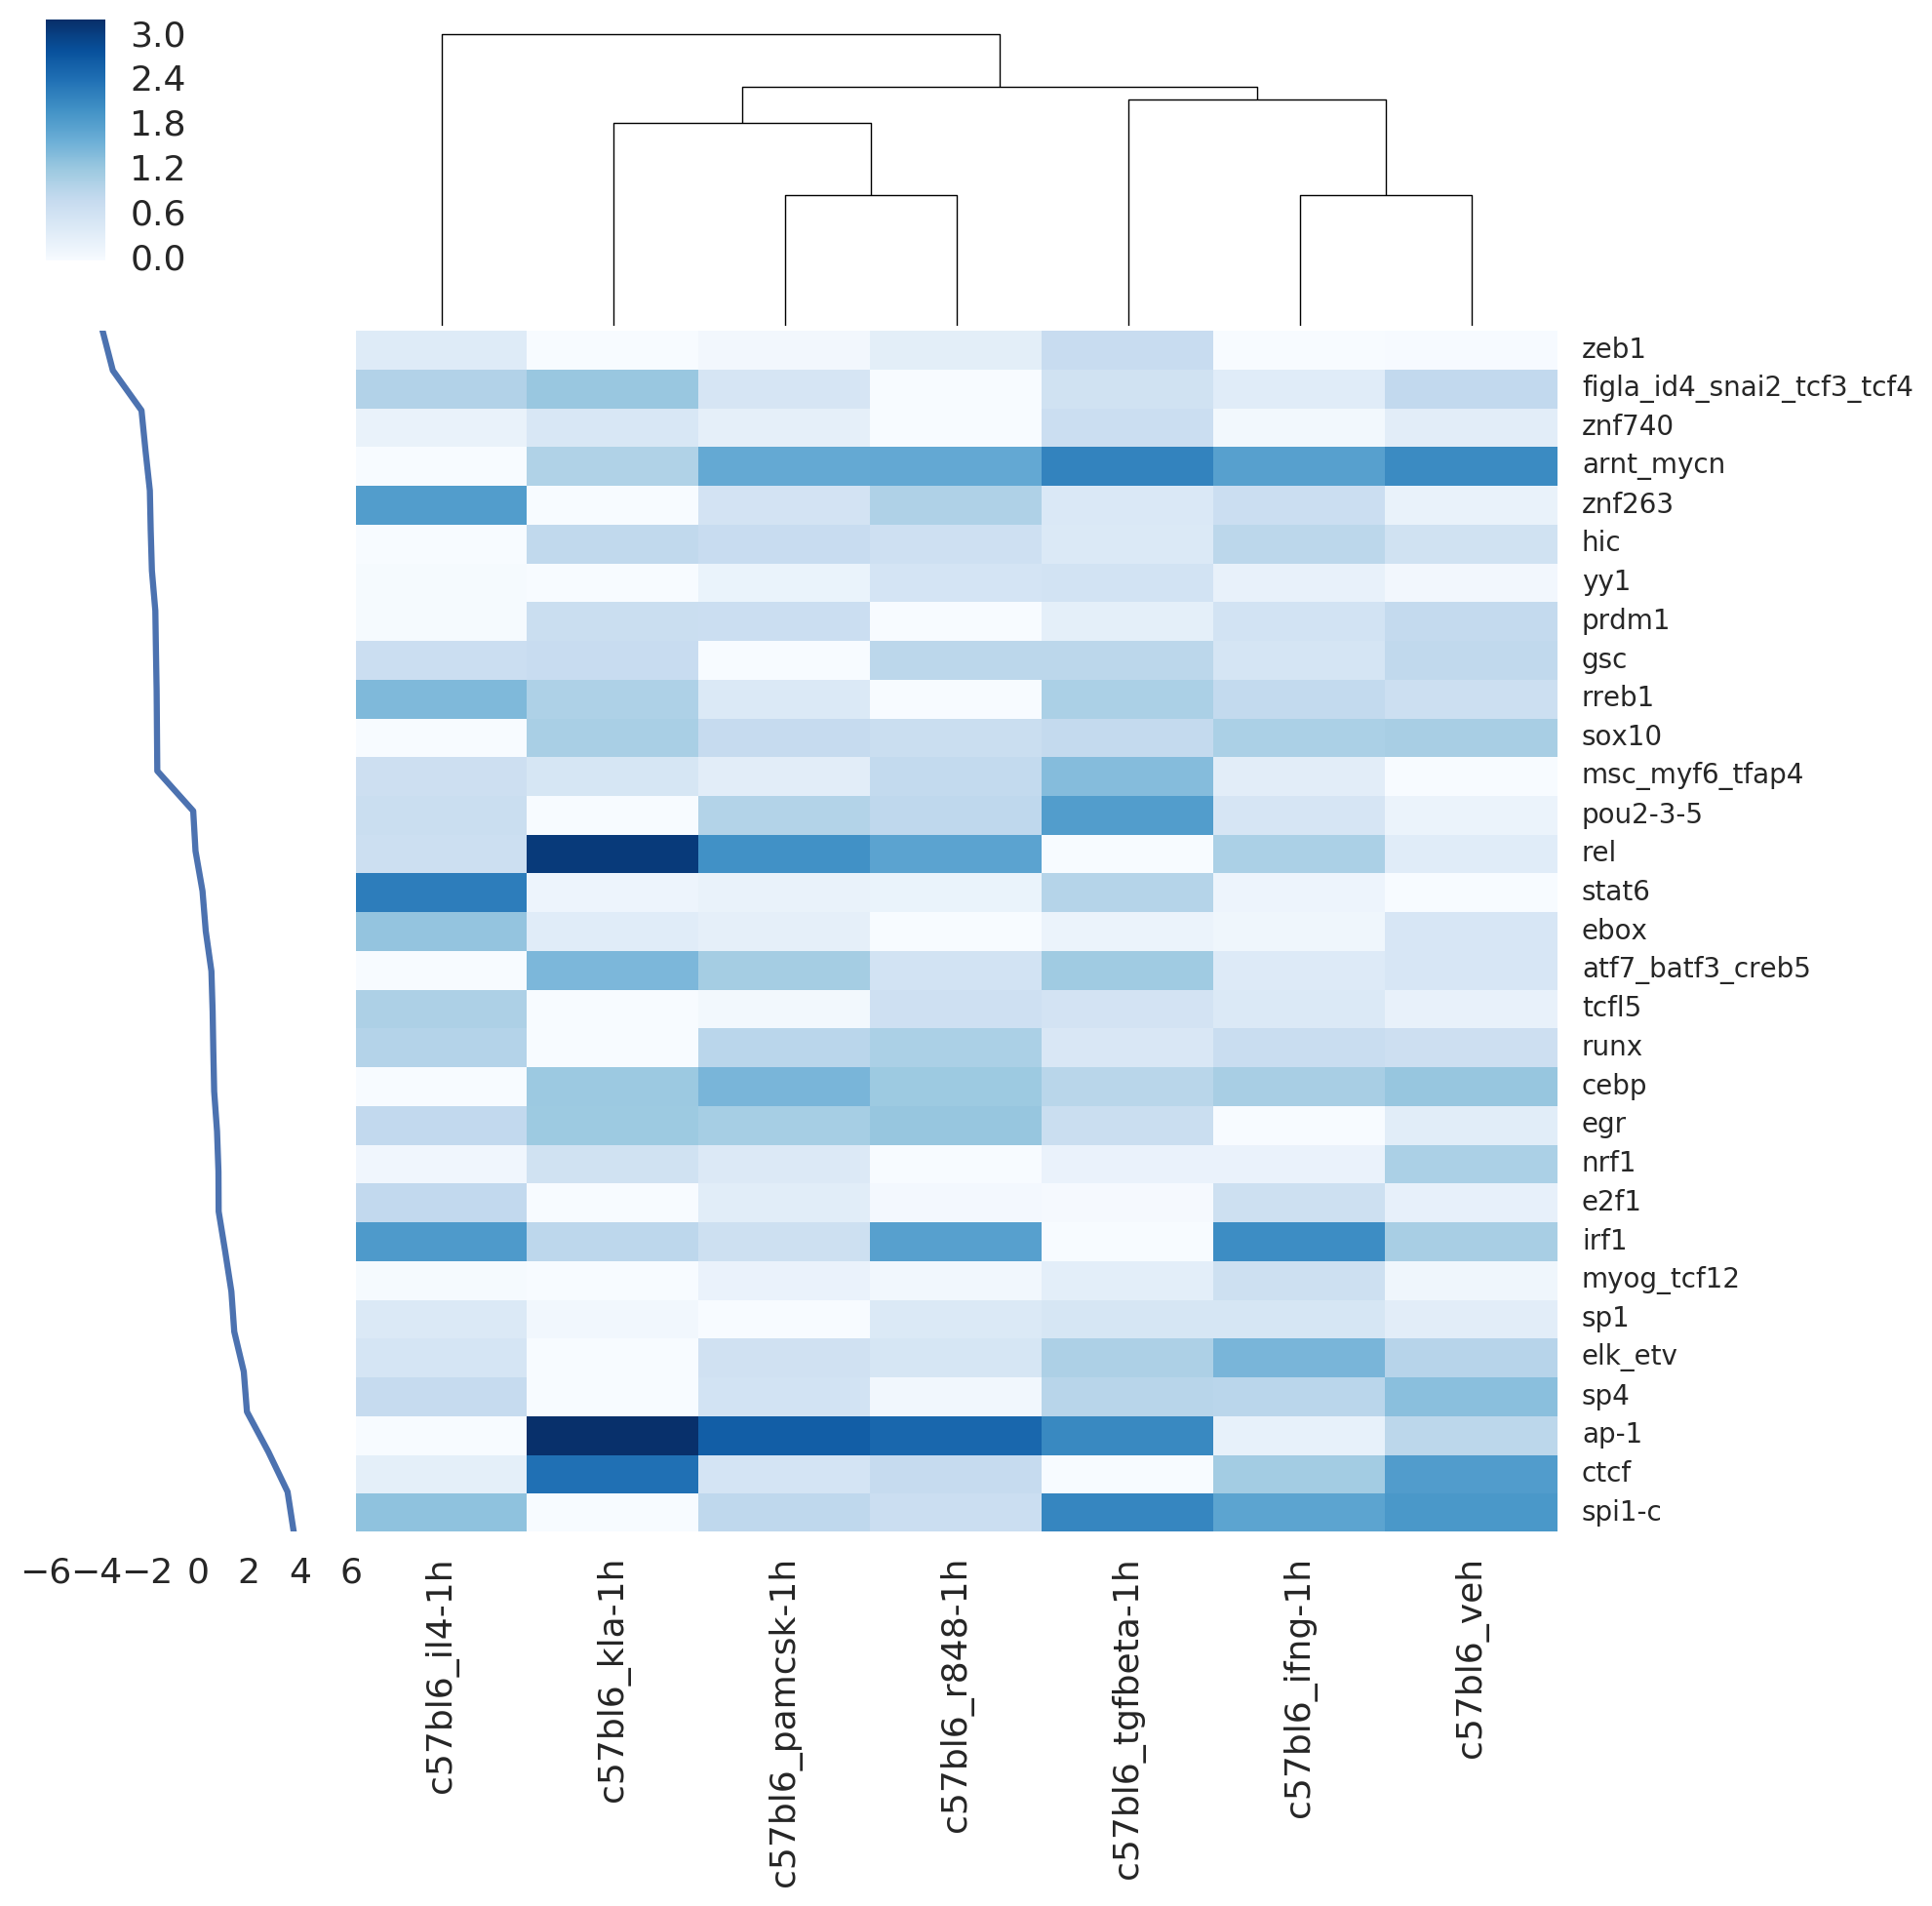

In [87]:
weight_threshold = 1.5
data = zscore_coeff_affinity_frame[
    (zscore_coeff_affinity_frame.max(axis=1) > 1* weight_threshold) |
    (zscore_coeff_affinity_frame.min(axis=1) < -1* weight_threshold)
]
mins = data.min(axis=1)

differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_differences = differences.ix[mins.index.values,:]
cg = sns.clustermap(sorted_differences,
                    col_cluster=True,
                   row_cluster=False,
                   cmap='Blues',
                  )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
cg.ax_row_dendrogram.clear()
cg.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cg.ax_row_dendrogram.set_yticks([])
cg.ax_row_dendrogram.set_xlim(-6,6)

In [89]:
zscore_coeff_affinity_frame.to_csv('weights.csv', sep='\t')

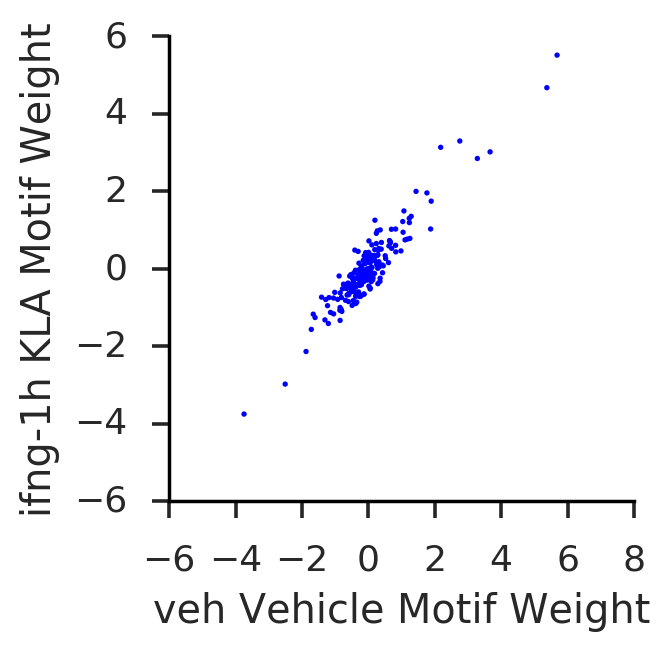

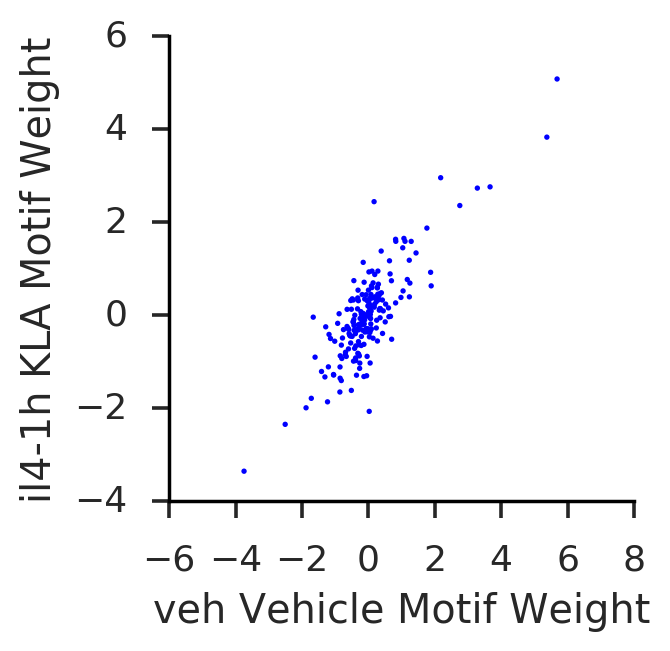

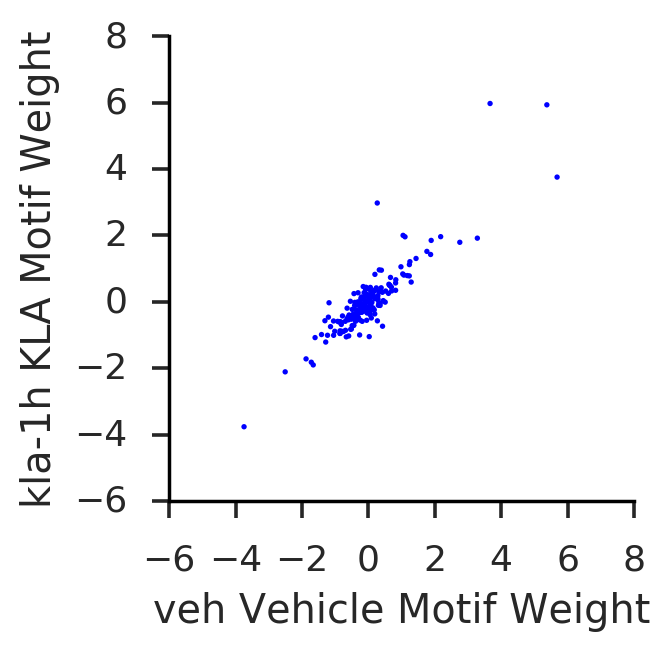

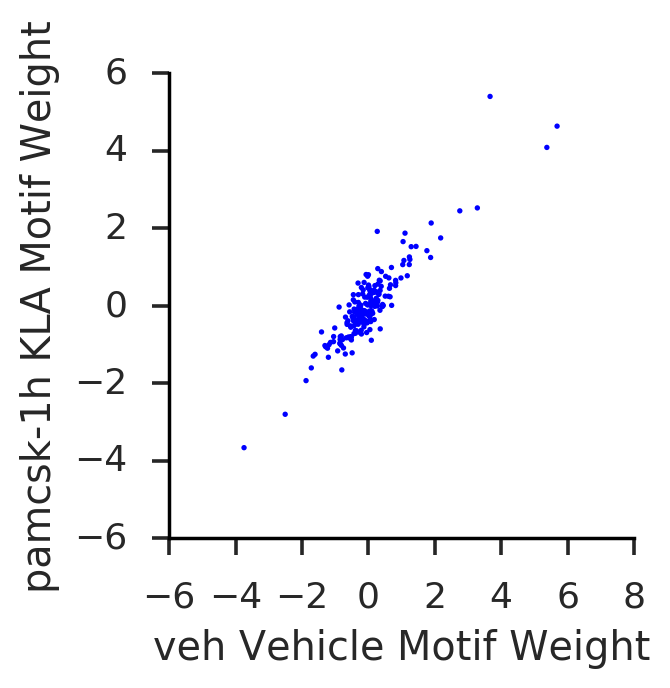

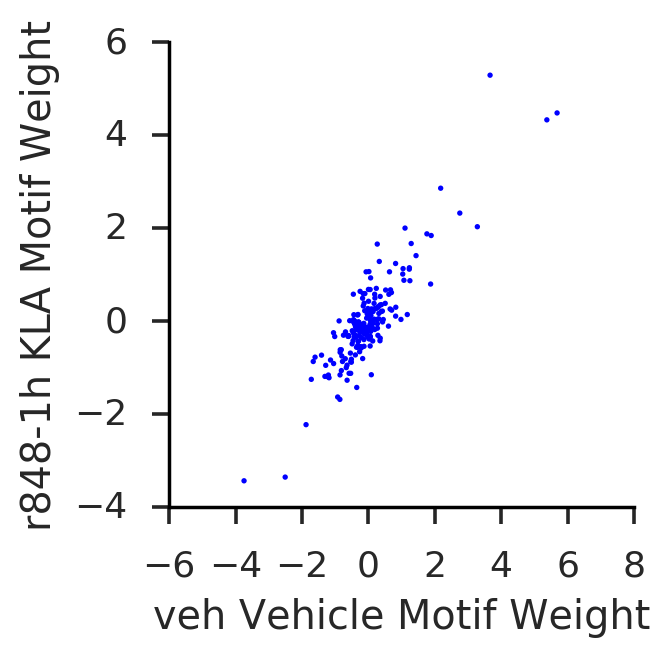

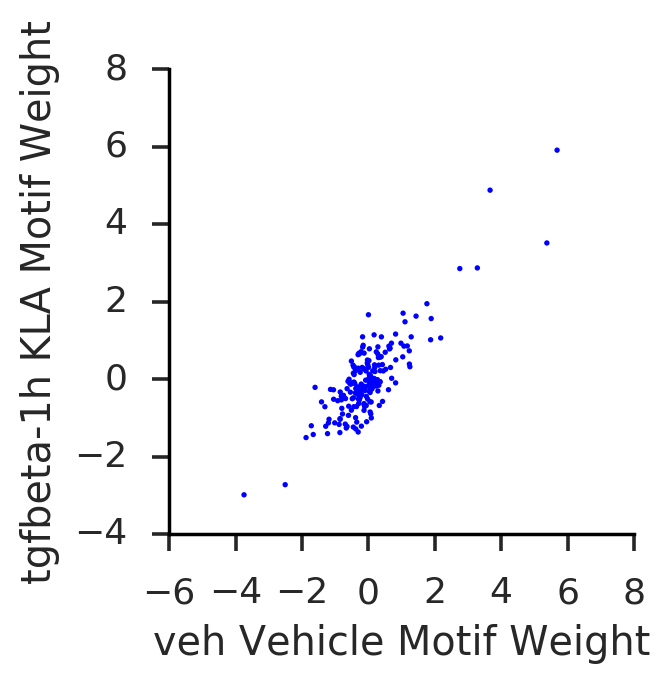

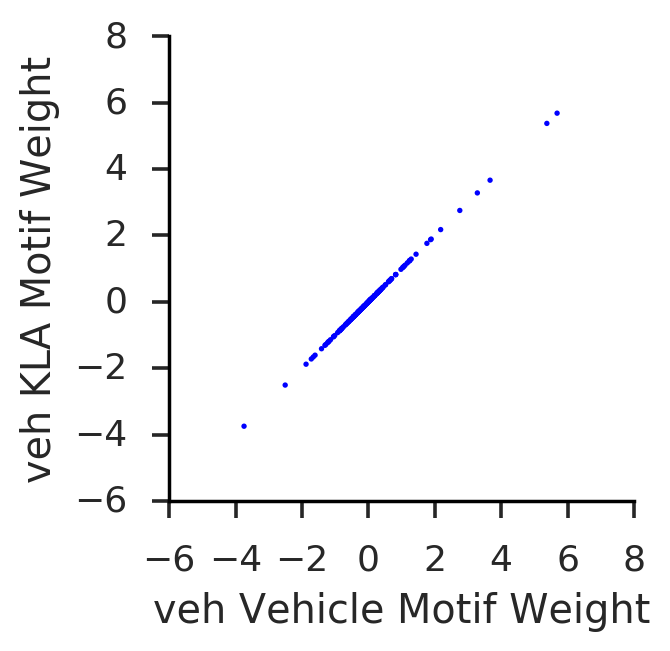

In [88]:
# scatterplot of weights
delta_threshold = 1.0
# targets = ['ap-1', 'cebp', 'rel', 'egr']
# targets = []
motifs = zscore_coeff_affinity_frame.index.values

for col in summary_frame.columns.values[5:]:
    
    factor1 = 'c57bl6_veh'
    factor2 = col
    with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                             }):
        plt.figure(figsize=(3,3))
        x_vals = zscore_coeff_affinity_frame[factor1]
        y_vals = zscore_coeff_affinity_frame[factor2]
        # calculate colors
        plt.scatter(x_vals,
                    y_vals,
                    marker = '.', 
                    s=15,
                    edgecolor='None')
        plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
        plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
        sns.despine()


        # calculate labels
#         for i in range(len(x_vals)):
#             x = x_vals[i]
#             y = y_vals[i]
#             if abs(x) >= 0.5 or abs(y) >= 0.5:
#                 delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
#                 if abs(delta) > delta_threshold or motifs[i] in targets:
#                     plt.annotate(motifs[i], xy=(x,y) , size=10)

        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.show()
    # plt.savefig('./figures/figure_05_b.svg', bbox_inches='tight')



In [99]:
peaks = []
types = []
conditions=[]
veh_indices = set(summary_frame[summary_frame['c57bl6_veh'] > 0.0].index.values)
for col in summary_frame.columns.values[5:]:
    target_indices = set(summary_frame[summary_frame[col] > 0.0].index.values)
    gained = len(target_indices - veh_indices)
    lost = len(veh_indices - target_indices)
    shared = len(veh_indices.intersection(target_indices))
    
    peaks.append(gained)
    peaks.append(lost)
    peaks.append(shared)
    types = types + ['Gained', 'Lost', 'Shared']
    conditions  = conditions + 3* [col.replace('c57bl6_','')]

In [100]:
frame = pd.DataFrame({'Num Peaks':peaks, 'Type':types, 'Condition':conditions})

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

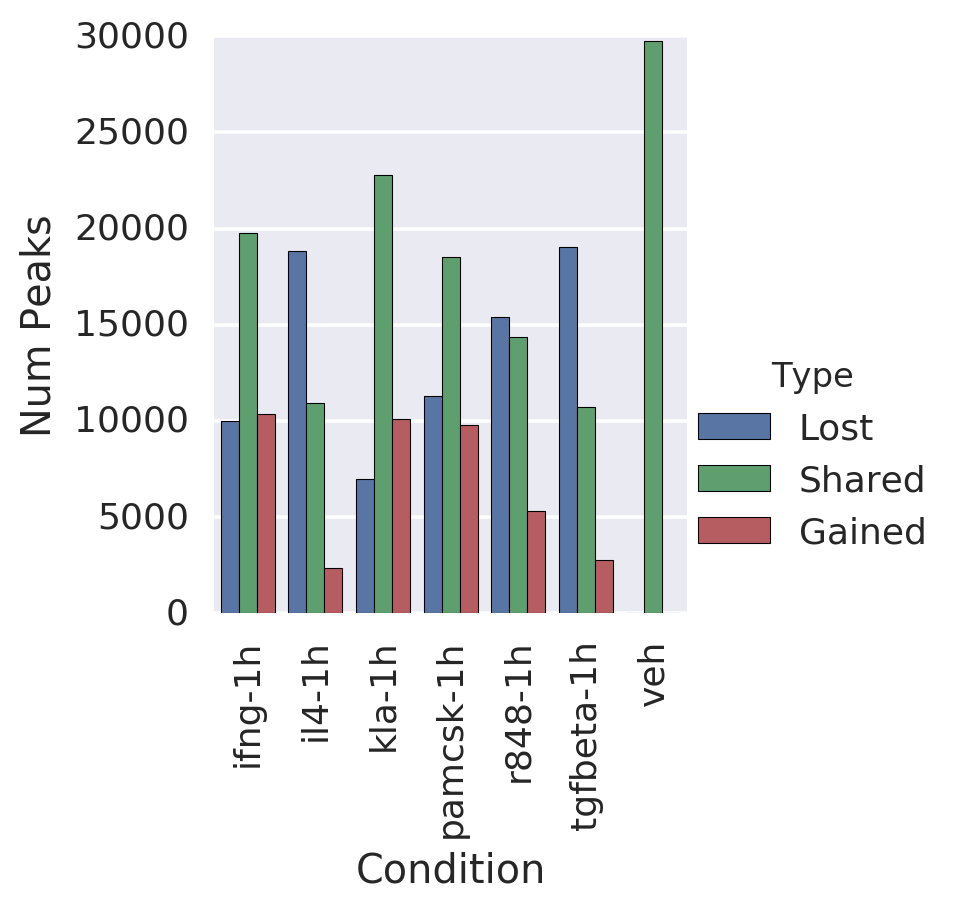

In [102]:
sns.factorplot(data=frame,x='Condition', y='Num Peaks', hue = 'Type', kind='bar', hue_order = ['Lost', 'Shared', 'Gained'])
plt.xticks(rotation=90)

## Calculating Differentially Expressed Genes

In [34]:
tag_dirs = sorted(os.listdir('./tag_directories_rna/'))
treated_dirs = ' '.join(['./tag_directories_rna/' + x for x in tag_dirs if not '_Veh-1h_' in x and ('KLA' in x or 'IFN' in x)])
veh_dirs = ' '.join(['./tag_directories_rna/' +x for x in tag_dirs if  '_Veh-1h_' in x])

In [36]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -noadj -d $veh_dirs $treated_dirs > raw.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep2
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
	Calc

In [37]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -rpkm -d $veh_dirs $treated_dirs > rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep2
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
	Calc

In [38]:
with open('./raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[8:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./raw.tsv $condition_string -AvsA > edgeR_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Veh-1h vs. IFNg-1h:
		Total Genes: 24453
		Total Up-regulated in IFNg-1h vs. Veh-1h: 63 (0.258%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IFNg-1h vs. Veh-1h: 142 (0.581%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. KLA-1h:
		Total Genes: 24453
		Total Up-regulated in KLA-1h vs. Veh-1h: 619 (2.531%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh-1h: 323 (1.321%) [log2fold<-1, FDR<0.05]
	Output Stats IFNg-1h vs. KLA-1h:
		Total Genes: 24453
		Total Up-regulated in KLA-1h vs. IFNg-1h: 2398 (9.807%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. IFNg-1h: 1862 (7.615%) [log2fold<-1, FDR<0.05]



In [39]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns